In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from scipy.stats import rankdata
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data loading
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
# ======= 1. Improved Feature Engineering =======
# Create new variables
for df in [train, test]:
    # Change rates of original variables
    df['temp_change_rate'] = df['temparature'].diff().fillna(0)
    df['humidity_change_trend'] = df['humidity'].diff().fillna(0)
    df['pressure_change'] = df['pressure'].diff().fillna(0)
    df['windspeed_change'] = df['windspeed'].diff().fillna(0)
    
    # Temperature range
    df['temp_range'] = df['maxtemp'] - df['mintemp']
    
    # Humidity to temperature ratio
    df['humidity_temp_ratio'] = df['humidity'] / (df['temparature'] + 0.1)  # avoid division by zero
    
    # Wind and pressure interaction
    df['wind_pressure_interaction'] = df['windspeed'] * df['pressure'] / 1000
    
    # Cloud and sunshine interaction
    df['cloud_sunshine_ratio'] = df['cloud'] / (df['sunshine'] + 0.1)  # avoid division by zero
    
    # Dewpoint and temperature difference
    df['dewpoint_temp_diff'] = df['temparature'] - df['dewpoint']
    
    # Add lag features (for important variables)
    for lag in [1, 2]:
        df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag).fillna(0)
        df[f'pressure_lag_{lag}'] = df['pressure'].shift(lag).fillna(0)
        df[f'temp_lag_{lag}'] = df['temparature'].shift(lag).fillna(0)

# Fill NA values with 0
train = train.fillna(0)
test = test.fillna(0)

RMV = ['rainfall', 'id']
FEATURES = [c for c in train.columns if c not in RMV]

In [4]:
# ======= 2. Handle Class Imbalance =======
# Check target variable distribution
rainfall_counts = train['rainfall'].value_counts()
print("Target variable distribution:", rainfall_counts)

# If imbalanced, use SMOTE
if min(rainfall_counts) / max(rainfall_counts) < 0.5:
    print("Imbalance detected, applying SMOTE oversampling...")
    X = train[FEATURES]
    y = train['rainfall']
    smote = SMOTE(random_state=42)
    
    # # Choose one of these options:
    # # Option 1: Enable SMOTE
    # X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Option 2: Don't use SMOTE but keep original data
    X_resampled, y_resampled = X, y
    
    # Convert back to DataFrame
    train_resampled = pd.DataFrame(X_resampled, columns=FEATURES)
    train_resampled['rainfall'] = y_resampled
    
    # Replace original training set (can be enabled if needed)
    train = train_resampled

Target variable distribution: rainfall
1    1650
0     540
Name: count, dtype: int64
Imbalance detected, applying SMOTE oversampling...


In [5]:
# ======= 3. Bayesian Optimization for XGBoost =======
def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, min_child_weight):
    """Bayesian optimization objective function - added min_child_weight parameter"""
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'min_child_weight': min_child_weight,
        'n_estimators': 10000,
        'eval_metric': 'auc',
        'early_stopping_rounds': 100  # Increased from 80
    }
    
    cv_scores = []
    train_auc_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(train):
        x_train = train.loc[train_idx, FEATURES]
        y_train = train.loc[train_idx, 'rainfall']
        x_val = train.loc[val_idx, FEATURES]
        y_val = train.loc[val_idx, 'rainfall']
        
        model = XGBClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            verbose=False
        )
        
        train_pred = model.predict_proba(x_train)[:, 1]
        val_pred = model.predict_proba(x_val)[:, 1]
        
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)
        
        cv_scores.append(val_auc)
        train_auc_scores.append(train_auc)
    
    # Calculate overfitting metric
    mean_train_auc = np.mean(train_auc_scores)
    mean_val_auc = np.mean(cv_scores)
    overfit_gap = mean_train_auc - mean_val_auc
    print(f"Train AUC = {mean_train_auc:.3f}, Val AUC = {mean_val_auc:.3f}, Overfitting = {overfit_gap:.3f}")
    
    # Penalize for severe overfitting
    if overfit_gap > 0.05:
        return mean_val_auc * 0.95  # Penalize overfitting parameter combinations
    elif overfit_gap > 0.1:
        return mean_val_auc * 0.9
    
    return mean_val_auc

In [6]:
# ======= 4. Bayesian Optimization for Random Forest =======
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    """Bayesian optimization objective function for Random Forest"""
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 42,
        'n_jobs': -1
    }
    
    cv_scores = []
    train_auc_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(train):
        x_train = train.loc[train_idx, FEATURES]
        y_train = train.loc[train_idx, 'rainfall']
        x_val = train.loc[val_idx, FEATURES]
        y_val = train.loc[val_idx, 'rainfall']
        
        model = RandomForestClassifier(**params)
        model.fit(x_train, y_train)
        
        train_pred = model.predict_proba(x_train)[:, 1]
        val_pred = model.predict_proba(x_val)[:, 1]
        
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)
        
        cv_scores.append(val_auc)
        train_auc_scores.append(train_auc)
    
    # Calculate overfitting metric
    mean_train_auc = np.mean(train_auc_scores)
    mean_val_auc = np.mean(cv_scores)
    overfit_gap = mean_train_auc - mean_val_auc
    print(f"RF Train AUC = {mean_train_auc:.3f}, Val AUC = {mean_val_auc:.3f}, Overfitting = {overfit_gap:.3f}")
    
    return mean_val_auc

In [7]:
# ======= 5. Run Bayesian Optimization for XGBoost =======
# Expanded parameter space
xgb_pbounds = {
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'gamma': (0, 2),
    'reg_alpha': (0.01, 5),
    'reg_lambda': (0.01, 5),
    'min_child_weight': (1, 10)
}

print("\n=== Starting XGBoost Optimization ===")
xgb_optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=xgb_pbounds,
    random_state=42,
    verbose=2
)

xgb_optimizer.maximize(init_points=15, n_iter=40)

# Get best XGBoost parameters
xgb_best_params = xgb_optimizer.max['params']
xgb_best_params['max_depth'] = int(xgb_best_params['max_depth'])
print('Best XGBoost parameters:', xgb_best_params)


=== Starting XGBoost Optimization ===
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
Train AUC = 0.973, Val AUC = 0.884, Overfitting = 0.090
| 1         | 0.8396    | 0.8124    | 1.901     | 0.2223    | 8.388     | 2.404     | 0.7884    | 0.2998    | 0.9599    |
Train AUC = 0.929, Val AUC = 0.894, Overfitting = 0.035
| 2         | 0.8938    | 0.8803    | 1.416     | 0.01597   | 11.73     | 8.492     | 1.07      | 0.9173    | 0.755     |
Train AUC = 0.947, Val AUC = 0.894, Overfitting = 0.053
| 3         | 0.8493    | 0.7913    | 1.05      | 0.1353    | 5.621     | 6.507     | 0.7061    | 1.468     | 0.8099    |
Train AUC = 0.940, Val AUC = 0.895, Overfitting = 0.045
| 4         | 0.8947    | 0.8368    | 1.57      | 0.06791   | 7.628     | 6.332     | 0.2418    | 3.042     | 0.7512    |
Train

In [8]:
# ======= 6. Run Bayesian Optimization for Random Forest =======
rf_pbounds = {
    'n_estimators': (50, 300),
    'max_depth': (3, 15),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

print("\n=== Starting Random Forest Optimization ===")
rf_optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=rf_pbounds,
    random_state=42,
    verbose=2
)

rf_optimizer.maximize(init_points=15, n_iter=40)

# Get best Random Forest parameters
rf_best_params = rf_optimizer.max['params']
rf_best_params['n_estimators'] = int(rf_best_params['n_estimators'])
rf_best_params['max_depth'] = int(rf_best_params['max_depth'])
print('Best Random Forest parameters:', rf_best_params)


=== Starting Random Forest Optimization ===
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
RF Train AUC = 0.955, Val AUC = 0.892, Overfitting = 0.063
| 1         | 0.8919    | 7.494     | 9.556     | 7.856     | 199.7     |
RF Train AUC = 0.921, Val AUC = 0.890, Overfitting = 0.031
| 2         | 0.8899    | 4.872     | 2.404     | 2.465     | 266.5     |
RF Train AUC = 0.973, Val AUC = 0.892, Overfitting = 0.081
| 3         | 0.8916    | 10.21     | 7.373     | 2.165     | 292.5     |
RF Train AUC = 0.998, Val AUC = 0.890, Overfitting = 0.108
| 4         | 0.89      | 12.99     | 2.911     | 3.455     | 95.85     |
RF Train AUC = 0.951, Val AUC = 0.891, Overfitting = 0.061
| 5         | 0.8907    | 6.651     | 5.723     | 5.456     | 122.8     |
RF Train AUC = 0.994, Val AUC = 0.890, Overfitting = 0.104
| 6         | 0.8899    | 10.34     | 2.255     | 4.337     | 141.6     |
RF Train 

In [9]:
# ======= 7. Cross-validation with optimized models =======
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Prepare arrays for predictions
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))
oof_rf = np.zeros(len(train))
pred_rf = np.zeros(len(test))

xgb_fold_train_auc = []
xgb_fold_val_auc = []
rf_fold_train_auc = []
rf_fold_val_auc = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, "rainfall"]
    x_valid = train.loc[test_index, FEATURES]
    y_valid = train.loc[test_index, "rainfall"]
    x_test = test[FEATURES]

    # XGBoost model
    xgb_model = XGBClassifier(
        max_depth=int(xgb_best_params['max_depth']),
        learning_rate=xgb_best_params['learning_rate'],
        subsample=xgb_best_params['subsample'],
        colsample_bytree=xgb_best_params['colsample_bytree'],
        gamma=xgb_best_params['gamma'],
        reg_alpha=xgb_best_params['reg_alpha'],
        reg_lambda=xgb_best_params['reg_lambda'],
        min_child_weight=xgb_best_params['min_child_weight'],
        n_estimators=10000,
        early_stopping_rounds=100,
        eval_metric='auc'
    )
    
    xgb_model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=100
    )
    
    # Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=int(rf_best_params['n_estimators']),
        max_depth=int(rf_best_params['max_depth']),
        min_samples_split=int(rf_best_params['min_samples_split']),
        min_samples_leaf=int(rf_best_params['min_samples_leaf']),
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(x_train, y_train)
    
    # XGBoost predictions
    xgb_train_pred = xgb_model.predict_proba(x_train)[:, 1]
    xgb_val_pred = xgb_model.predict_proba(x_valid)[:, 1]
    xgb_test_pred = xgb_model.predict_proba(x_test)[:, 1]
    
    # Random Forest predictions
    rf_train_pred = rf_model.predict_proba(x_train)[:, 1]
    rf_val_pred = rf_model.predict_proba(x_valid)[:, 1]
    rf_test_pred = rf_model.predict_proba(x_test)[:, 1]
    
    # Store XGBoost metrics
    xgb_train_auc = roc_auc_score(y_train, xgb_train_pred)
    xgb_val_auc = roc_auc_score(y_valid, xgb_val_pred)
    xgb_fold_train_auc.append(xgb_train_auc)
    xgb_fold_val_auc.append(xgb_val_auc)
    
    # Store Random Forest metrics
    rf_train_auc = roc_auc_score(y_train, rf_train_pred)
    rf_val_auc = roc_auc_score(y_valid, rf_val_pred)
    rf_fold_train_auc.append(rf_train_auc)
    rf_fold_val_auc.append(rf_val_auc)
    
    # Store out-of-fold predictions
    oof_xgb[test_index] = xgb_val_pred
    oof_rf[test_index] = rf_val_pred
    
    # Accumulate test predictions
    pred_xgb += xgb_test_pred / FOLDS
    pred_rf += rf_test_pred / FOLDS
    
    print(f"XGBoost - Train AUC: {xgb_train_auc:.4f}, Val AUC: {xgb_val_auc:.4f}")
    print(f"Random Forest - Train AUC: {rf_train_auc:.4f}, Val AUC: {rf_val_auc:.4f}")

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.82732
[100]	validation_0-auc:0.86568
[118]	validation_0-auc:0.86397
XGBoost - Train AUC: 0.9358, Val AUC: 0.8731
Random Forest - Train AUC: 0.9759, Val AUC: 0.8714
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.82043
[100]	validation_0-auc:0.87927
[115]	validation_0-auc:0.87998
XGBoost - Train AUC: 0.9287, Val AUC: 0.8907
Random Forest - Train AUC: 0.9752, Val AUC: 0.8937
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.86969
[100]	validation_0-auc:0.89041
[106]	validation_0-auc:0.89024
XGBoost - Train AUC: 0.9132, Val AUC: 0.8969
Random Forest - Train AUC: 0.9747, Val AUC: 0.8911
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.89667
[100]	validation_0-auc:0.93153
[122]	validation_0-auc:0.93252
XGBoost - Train AUC: 0.9333, Val AUC: 0.9395
Random Forest - Train AUC: 0.9730, Val AUC: 0.9297


In [11]:
# ======= 8. Optimize ensemble weights =======
# Function to find optimal weights for ensemble
def optimize_weights(oof_preds, y_true):
    """Find optimal weights for model blending using simple grid search"""
    best_score = 0
    best_weights = None
    
    for w1 in range(0, 11, 1):  # 0 to 1 with 0.1 step
        w1 = w1 / 10
        w2 = 1 - w1
        
        # Blend predictions
        blend_preds = w1 * oof_preds[0] + w2 * oof_preds[1]
        score = roc_auc_score(y_true, blend_preds)
        
        if score > best_score:
            best_score = score
            best_weights = (w1, w2)
    
    return best_weights, best_score

# Optimize weights for XGBoost and RF ensemble
weights, score = optimize_weights([oof_xgb, oof_rf], train['rainfall'])
print(f"Optimized ensemble weights: XGBoost={weights[0]:.2f}, RF={weights[1]:.2f}, Score={score:.4f}")

Optimized ensemble weights: XGBoost=0.60, RF=0.40, Score=0.8913


In [12]:
# ======= 9. Dynamic threshold optimization =======
# Find optimal thresholds for classification
def find_optimal_thresholds(oof_preds, y_true):
    """Find upper and lower thresholds for classification adjustment"""
    best_score = roc_auc_score(y_true, oof_preds)
    best_thresholds = (0.05, 0.95)  # Default thresholds
    
    for lower in range(1, 15, 1):  # 0.01 to 0.15
        lower = lower / 100
        for upper in range(85, 100, 1):  # 0.85 to 0.99
            upper = upper / 100
            
            # Copy predictions
            adjusted_preds = oof_preds.copy()
            
            # Apply thresholds
            adjusted_preds[adjusted_preds < lower] = 0
            adjusted_preds[adjusted_preds > upper] = 1
            
            # Calculate score
            score = roc_auc_score(y_true, adjusted_preds)
            
            if score > best_score:
                best_score = score
                best_thresholds = (lower, upper)
    
    return best_thresholds, best_score

# Calculate ensemble OOF predictions
oof_ensemble = weights[0] * oof_xgb + weights[1] * oof_rf

# Find optimal thresholds
thresholds, threshold_score = find_optimal_thresholds(oof_ensemble, train['rainfall'])
print(f"Optimal thresholds: Lower={thresholds[0]:.2f}, Upper={thresholds[1]:.2f}, Score={threshold_score:.4f}")

Optimal thresholds: Lower=0.13, Upper=0.97, Score=0.8913


In [13]:
# ======= 10. Create final predictions and submission file =======
# Combine XGBoost and Random Forest predictions with optimal weights
final_pred = weights[0] * pred_xgb + weights[1] * pred_rf

# Try to load external best submission if available (for ensemble)
try:
    best_public = pd.read_csv("/kaggle/input/0-96245-lda-lgs-ensemble-for-rainfall-pred/submission.csv")
    best_public = best_public.rainfall.values
    
    # Enhanced ensemble with external prediction
    ensemble_pred = 0.7 * rankdata(final_pred) + 0.3 * rankdata(best_public)
    ensemble_pred = rankdata(ensemble_pred) / len(ensemble_pred)
    
    print("Successfully integrated external predictions in ensemble")
    final_pred = ensemble_pred
except:
    print("External predictions not available, using only current models")

# Apply optimized thresholds to final predictions
final_pred_adjusted = final_pred.copy()
final_pred_adjusted[final_pred < thresholds[0]] = 0
final_pred_adjusted[final_pred > thresholds[1]] = 1

# Create submission file
sample = pd.read_csv("outputs/sample_submission.csv")
sample.rainfall = final_pred_adjusted
sample.to_csv("outputs/submission_25.03.csv", index=False)
print("Final submission file created")

External predictions not available, using only current models
Final submission file created


In [14]:
# Predict with the best XGBoost model
xgb_final_pred = xgb_model.predict_proba(test[FEATURES])[:, 1]

# Apply optimized thresholds to XGBoost predictions
xgb_final_pred_adjusted = xgb_final_pred.copy()
xgb_final_pred_adjusted[xgb_final_pred < thresholds[0]] = 0
xgb_final_pred_adjusted[xgb_final_pred > thresholds[1]] = 1

# Create submission file for XGBoost
xgb_submission = pd.read_csv("outputs/sample_submission.csv")
xgb_submission['rainfall'] = xgb_final_pred
xgb_submission.to_csv("outputs/submission_25.03_xgb.csv", index=False)
print("XGBoost submission file created: outputs/submission_23.03_xgb.csv")

# Predict with the best Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=int(rf_best_params['n_estimators']),
    max_depth=int(rf_best_params['max_depth']),
    min_samples_split=int(rf_best_params['min_samples_split']),
    min_samples_leaf=int(rf_best_params['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)
rf_model.fit(train[FEATURES], train['rainfall'])
rf_final_pred = rf_model.predict_proba(test[FEATURES])[:, 1]

# Create submission file for Random Forest
rf_submission = pd.read_csv("outputs/sample_submission.csv")
rf_submission['rainfall'] = rf_final_pred
rf_submission.to_csv("outputs/submission_25.03_rf.csv", index=False)
print("Random Forest submission file created: outputs/submission_23.03_rf.csv")

XGBoost submission file created: outputs/submission_23.03_xgb.csv
Random Forest submission file created: outputs/submission_23.03_rf.csv



===== Model Performance Analysis =====
XGBoost - Train AUC: 0.9292, Val AUC: 0.8971, Gap: 0.0321
Random Forest - Train AUC: 0.9748, Val AUC: 0.8932, Gap: 0.0816
Ensemble - Val AUC: 0.8913


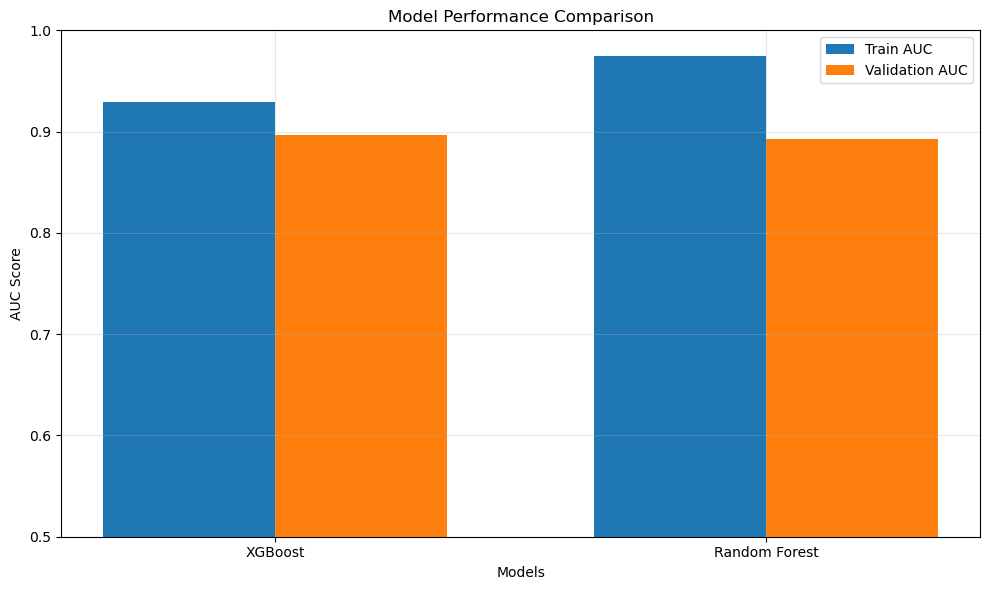

In [15]:
# ======= 11. Model performance analysis =======
# Overfitting analysis for both models
print("\n===== Model Performance Analysis =====")
xgb_mean_train_auc = np.mean(xgb_fold_train_auc)
xgb_mean_val_auc = np.mean(xgb_fold_val_auc)
xgb_overfit_gap = xgb_mean_train_auc - xgb_mean_val_auc

rf_mean_train_auc = np.mean(rf_fold_train_auc)
rf_mean_val_auc = np.mean(rf_fold_val_auc)
rf_overfit_gap = rf_mean_train_auc - rf_mean_val_auc

print(f"XGBoost - Train AUC: {xgb_mean_train_auc:.4f}, Val AUC: {xgb_mean_val_auc:.4f}, Gap: {xgb_overfit_gap:.4f}")
print(f"Random Forest - Train AUC: {rf_mean_train_auc:.4f}, Val AUC: {rf_mean_val_auc:.4f}, Gap: {rf_overfit_gap:.4f}")
print(f"Ensemble - Val AUC: {score:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
models = ['XGBoost', 'Random Forest']
train_aucs = [xgb_mean_train_auc, rf_mean_train_auc]
val_aucs = [xgb_mean_val_auc, rf_mean_val_auc]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_aucs, width, label='Train AUC')
plt.bar(x + width/2, val_aucs, width, label='Validation AUC')

plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()